In [6]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import f1_score
import time
from statistics import mean
import math
import random

In [7]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [8]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [9]:
downloaded = drive.CreateFile({'id': '1IQfiGz6c3poQStcSRjW-2NVrna3fU29t'})
downloaded.GetContentFile('dataset.pkl')

In [10]:
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [37]:
# Ustawienie ziarna
seed_value = 1234

tf.random.set_seed(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [12]:
def get_data(part):
    images = dataset[part]['X']
    labels = dataset[part]['y']
    
    return images, labels


def images_preprocessing(images):
    # Zmiana rozmiaru obrazu z 224x224 do 64x64
    images = tf.image.resize(
        images, [64, 64], 
        method=tf.image.ResizeMethod.NEAREST_NEIGHBOR, 
        preserve_aspect_ratio=False,
        name=None
    )
    
    # Spłaszczanie obrazów do jednego wymiaru (np. z 64x64x3 do 12288)
    #images = tf.reshape(images, [images.shape[0], -1])
    
    # Zmiana typu obrazów z int na float 
    # i normalizacja wartości pikseli z przedziału 0-255 do przedziału 0-1
    images = tf.cast(images, tf.float32) / 255.0
    
    return images


def labels_preprocessing(labels):
    # Zmiana wymiarowości z [8870] na [8870, 1] 
    # w celu zastosowania `SparseCategoricalCrossentropy`
    labels = tf.reshape(labels, [-1, 1])
    
    return labels


def dataset_to_batches(X, y, batch_size=100):
    # Preprocess images
    images = images_preprocessing(X)
    # Preprocess labels
    labels = labels_preprocessing(y)
    
    # Do iterowania zbioru danych i podzielenia na paczki (ang. batch) 
    # można wykorzystać interfejs zdefiniowany w `tensorflow.data.Dataset`
    ds = tf.data.Dataset.from_tensor_slices((images, labels)) 
    ds = ds.shuffle(buffer_size=len(images)).batch(batch_size=batch_size)
    
    return ds

In [38]:
# Wczytanie mechanizmu paczkowania dla zbiorów
train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y)

test_X, test_y = get_data("test")
test_ds = dataset_to_batches(test_X, test_y)

val_X, val_y = get_data("validation")
val_ds = dataset_to_batches(val_X, val_y)

In [39]:
class CNNModel(tf.keras.Model):
    def __init__(self, kernel_size, pool_size, pooling):
        super(CNNModel, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=kernel_size, 
                                            strides=(1,1), 
                                            use_bias=True, 
                                            input_shape=(64, 64, 3))
        self.pool1 = pooling(pool_size=pool_size, 
                             strides=(2,2))
        
        self.conv2 = tf.keras.layers.Conv2D(filters=64, 
                                            kernel_size=kernel_size, 
                                            strides=(1,1), 
                                            use_bias=True)
        self.pool2 = pooling(pool_size=pool_size, 
                             strides=(2,2))
        
        self.flat = tf.keras.layers.Flatten()
        
        self.fc1 = tf.keras.layers.Dense(units=384)
        self.fc2 = tf.keras.layers.Dense(units=192)
        self.fc3 = tf.keras.layers.Dense(units=14)
        
        
    def call(self, inputs, training=False):
        conv1_out = tf.keras.activations.relu(self.conv1(inputs))
        pool1_out = self.pool1(conv1_out)
        
        conv2_out = tf.keras.activations.relu(self.conv2(pool1_out))
        pool2_out = self.pool2(conv2_out)
        
        flat_out = self.flat(pool2_out)
        
        fc1_out = tf.keras.activations.relu(self.fc1(flat_out))
        fc2_out = tf.keras.activations.relu(self.fc2(fc1_out))
        fc3_out = tf.keras.activations.softmax(self.fc3(fc2_out))
        
        return fc3_out
    
    
    def fit(self, **kwargs):
        self.loss_list = []
        self.f1_list = []
        self.time_list = []
        
        self.test_loss_list = []
        self.test_f1_list = []
        
        self.val_loss_list = []
        self.val_f1_list = []
        
        ds_train = kwargs.get("ds_train", train_ds)
        ds_test = kwargs.get("ds_test", test_ds)
        ds_val = kwargs.get("ds_val", val_ds)
        
        batch_size = kwargs.get("batch_size", 100)
        learning_rate = kwargs.get("learning_rate", 0.001)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam)
        optimizer = optimizer(learning_rate=learning_rate)
        epochs = kwargs.get("epochs", 25)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        
        for epoch in range(epochs):
            f1 = tfa.metrics.F1Score(num_classes=14, average="macro")
            timer_start = time.time()
            
            for X, y in ds_train:
                with tf.GradientTape() as tape:
                    logits = self.call(X)
                    loss = cost_func(y, logits)
                    
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.loss_list.append(loss)
                self.f1_list.append(f1.result())
            
            #self.f1_list.append(f1.result())
            
            exec_time = time.time() - timer_start
            self.time_list.append(exec_time)
            
            print('TRAINING: Epoch: %d  -  loss: %.3f; F1_score: %.3f; time: %.3fs'%(epoch, 
                                                                                     self.loss_list[-1], 
                                                                                     self.f1_list[-1], 
                                                                                     self.time_list[-1]))
            
            for X, y in ds_test:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.test_loss_list.append(loss)
                self.test_f1_list.append(f1.result())
            
            print('TEST: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                    self.test_loss_list[-1], 
                                                                    self.test_f1_list[-1]))
            
            for X, y in ds_val:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.val_loss_list.append(loss)
                self.val_f1_list.append(f1.result())
            
            print('VALIDATION: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                          self.val_loss_list[-1], 
                                                                          self.val_f1_list[-1]))
            

    def predict(self, X):
        logits = self.call(X)
        pred = tf.argmax(logits, axis=1)
        
        return pred

In [40]:
train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y)

test_X, test_y = get_data("test")
test_X = images_preprocessing(test_X)
test_y = labels_preprocessing(test_y)


def cnn_model_experiment(ds_train=train_ds, 
                         ds_test=test_ds, 
                         ds_val=val_ds, 
                         test_X=test_X, 
                         test_y=test_y, 
                         batch_size=100, 
                         learning_rate=0.001, 
                         optimizer=tf.keras.optimizers.Adam, 
                         epochs=25, 
                         cost_func=tf.keras.losses.SparseCategoricalCrossentropy(), 
                         kernel_size=(3,3), 
                         pool_size=(4,4), 
                         pooling=tf.keras.layers.MaxPooling2D):
    model = CNNModel(kernel_size=kernel_size, 
                     pool_size=pool_size, 
                     pooling=pooling)
    
    model.fit(ds_train=ds_train, 
              ds_test=ds_test, 
              ds_val=ds_val, 
              batch_size=batch_size, 
              learning_rate=learning_rate, 
              optimizer=optimizer,
              epochs=epochs, 
              cost_func=cost_func)
    
    el_per_batch = math.ceil(len(train_X) / batch_size)
    loss_list = np.asarray(model.loss_list)
    loss_list = np.mean(loss_list.reshape(-1, el_per_batch), axis=1)

    y_pred = model.predict(test_X)
    f1 = f1_score(test_y, y_pred, average='micro')
    
    return model, f1, loss_list

Task 1: Data Augmentation

In [101]:
class CNNModelDataAugmentation(CNNModel):
    def __init__(self, kernel_size, pool_size, pooling):
        super(CNNModelDataAugmentation, self).__init__(kernel_size, pool_size, pooling)

    
    def fit(self, **kwargs):
        self.loss_list = []
        self.f1_list = []
        self.time_list = []
        
        self.test_loss_list = []
        self.test_f1_list = []
        
        self.val_loss_list = []
        self.val_f1_list = []
        
        ds_train = kwargs.get("ds_train", train_ds)
        ds_test = kwargs.get("ds_test", test_ds)
        ds_val = kwargs.get("ds_val", val_ds)
        
        batch_size = kwargs.get("batch_size", 100)
        learning_rate = kwargs.get("learning_rate", 0.001)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam)
        optimizer = optimizer(learning_rate=learning_rate)
        epochs = kwargs.get("epochs", 25)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())

        augm_type = kwargs.get("augm_type", 'none')
        
        for epoch in range(epochs):
            f1 = tfa.metrics.F1Score(num_classes=14, average="macro")
            timer_start = time.time()
            
            for X, y in ds_train:
                if augm_type != 'none' and random.random() > 0.5:
                    X = self.augmentation(X, augm_type)

                with tf.GradientTape() as tape:
                    logits = self.call(X)
                    loss = cost_func(y, logits)
                    
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.loss_list.append(loss)
                self.f1_list.append(f1.result())
            
            #self.f1_list.append(f1.result())
            
            exec_time = time.time() - timer_start
            self.time_list.append(exec_time)
            
            print('TRAINING: Epoch: %d  -  loss: %.3f; F1_score: %.3f; time: %.3fs'%(epoch, 
                                                                                     self.loss_list[-1], 
                                                                                     self.f1_list[-1], 
                                                                                     self.time_list[-1]))
            
            for X, y in ds_test:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.test_loss_list.append(loss)
                self.test_f1_list.append(f1.result())
            
            print('TEST: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                    self.test_loss_list[-1], 
                                                                    self.test_f1_list[-1]))
            
            for X, y in ds_val:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.val_loss_list.append(loss)
                self.val_f1_list.append(f1.result())
            
            print('VALIDATION: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                          self.val_loss_list[-1], 
                                                                          self.val_f1_list[-1]))
            
    def augmentation(self, X, augm_type='random'):
        # https://www.wouterbulten.nl/blog/tech/data-augmentation-using-tensorflow-data-dataset/
        
        if augm_type == 'random':
            augm_type = random.choice(['flip', 'rotate', 'adjustments'])

        if augm_type == 'flip':
            X = tf.image.random_flip_left_right(X)
            X = tf.image.random_flip_up_down(X)
        elif augm_type == 'rotate':
            X = tf.image.rot90(X, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
        elif augm_type == 'adjustments':
            X = tf.image.random_brightness(X, 0.2)
            X = tf.image.random_contrast(X, 0.75, 1.25)
            X = tf.image.random_hue(X, 0.1)
            X = tf.image.random_saturation(X, 0.6, 1.4)
        elif augm_type == 'noise':
            X = tf.image.random_jpeg_quality(X, 50, 100)

        return X


In [102]:
train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y)

test_X, test_y = get_data("test")
test_X = images_preprocessing(test_X)
test_y = labels_preprocessing(test_y)


def cnn_model_da_experiment(ds_train=train_ds, 
                            ds_test=test_ds, 
                            ds_val=val_ds, 
                            test_X=test_X, 
                            test_y=test_y, 
                            batch_size=100, 
                            learning_rate=0.001, 
                            optimizer=tf.keras.optimizers.Adam, 
                            epochs=25, 
                            cost_func=tf.keras.losses.SparseCategoricalCrossentropy(), 
                            augm_type='none', 
                            kernel_size=(3,3), 
                            pool_size=(4,4), 
                            pooling=tf.keras.layers.MaxPooling2D):
    model = CNNModelDataAugmentation(kernel_size=kernel_size, 
                                     pool_size=pool_size, 
                                     pooling=pooling)
    
    model.fit(ds_train=ds_train, 
              ds_test=ds_test, 
              ds_val=ds_val, 
              batch_size=batch_size, 
              learning_rate=learning_rate, 
              optimizer=optimizer,
              epochs=epochs, 
              cost_func=cost_func,
              augm_type=augm_type)
    
    el_per_batch = math.ceil(len(train_X) / batch_size)
    loss_list = np.asarray(model.loss_list)
    loss_list = np.mean(loss_list.reshape(-1, el_per_batch), axis=1)

    y_pred = model.predict(test_X)
    f1 = f1_score(test_y, y_pred, average='micro')
    
    return model, f1, loss_list

In [103]:
settings_augm_type = ['none', 'flip', 'rotate', 'adjustments', 'random']

res_df = pd.DataFrame(columns=['experiment', 
                               'f1_score', 'loss', 'time_per_epoch', 'time'])

In [ ]:
batch_size = 100
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam
epochs = 25
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
kernel_size = (5,5)
pool_size = (4,4)
pooling = tf.keras.layers.MaxPooling2D


for augm_type in settings_augm_type:
    tf.random.set_seed(1234)
    
    train_X, train_y = get_data("train")
    train_ds = dataset_to_batches(train_X, train_y, batch_size)

    model, f1, loss_list = cnn_model_da_experiment(ds_train=train_ds, 
                                                   #test_X=test_X, 
                                                   #test_y=test_y, 
                                                   batch_size=batch_size, 
                                                   learning_rate=learning_rate, 
                                                   optimizer=optimizer, 
                                                   epochs=epochs, 
                                                   cost_func=cost_func, 
                                                   augm_type=augm_type, 
                                                   kernel_size=kernel_size, 
                                                   pool_size=pool_size, 
                                                   pooling=pooling)
    
    res_df = res_df.append({'experiment': 'DA: ' + augm_type, 
                            'f1_score': f1, 
                            'loss': loss_list[-1], 
                            'time_per_epoch': np.mean(model.time_list), 
                            'time': np.sum(model.time_list)}, ignore_index=True)
    
    print(f1)

In [107]:
res_df

experiment  f1_score      loss  time_per_epoch        time
0         DA: none  0.403911  1.094461        4.203111  105.077770
1         DA: flip  0.399528  1.629077        4.322323  108.058076
2       DA: rotate  0.385030  1.787374        4.331269  108.281717
3  DA: adjustments  0.388402  1.276243        4.341320  108.533002
4       DA: random  0.389751  1.727489        4.356778  108.919448

In [108]:
#res_df.to_csv('task_1_results.csv')

Task 2: Regularization - Dropout & Weight decay

In [122]:
class CNNModelRegularization(CNNModel):
    def __init__(self, kernel_size, pool_size, pooling, dropout_approach):
        super(CNNModelRegularization, self).__init__(kernel_size, pool_size, pooling)

        self.drop1 = tf.keras.layers.Dropout(rate=0.1)
        self.drop2 = tf.keras.layers.Dropout(rate=0.5)
        self.dropout_approach = dropout_approach
        
        
    def call(self, inputs, training=False):
        conv1_out = tf.keras.activations.relu(self.conv1(inputs))
        pool1_out = self.pool1(conv1_out)
        if 'conv'in self.dropout_approach:
            pool1_out = self.drop1(pool1_out, training=training)
        
        conv2_out = tf.keras.activations.relu(self.conv2(pool1_out))
        pool2_out = self.pool2(conv2_out)
        if 'conv'in self.dropout_approach:
            pool2_out = self.drop1(pool2_out, training=training)
        
        flat_out = self.flat(pool2_out)
        
        fc1_out = tf.keras.activations.relu(self.fc1(flat_out))
        if 'dense'in self.dropout_approach:
            fc1_out = self.drop2(fc1_out, training=training)
        fc2_out = tf.keras.activations.relu(self.fc2(fc1_out))
        if 'dense'in self.dropout_approach:
            fc2_out = self.drop2(fc2_out, training=training)
        fc3_out = tf.keras.activations.softmax(self.fc3(fc2_out))
        
        return fc3_out
    

    def fit(self, **kwargs):
        self.loss_list = []
        self.f1_list = []
        self.time_list = []
        
        self.test_loss_list = []
        self.test_f1_list = []
        
        self.val_loss_list = []
        self.val_f1_list = []
        
        ds_train = kwargs.get("ds_train", train_ds)
        ds_test = kwargs.get("ds_test", test_ds)
        ds_val = kwargs.get("ds_val", val_ds)
        
        batch_size = kwargs.get("batch_size", 100)
        learning_rate = kwargs.get("learning_rate", 0.001)
        weight_decay = kwargs.get('weight_decay', None)
        optimizer = kwargs.get("optimizer", tf.keras.optimizers.Adam)
        if weight_decay:
            optimizer = optimizer(weight_decay=weight_decay, learning_rate=learning_rate)
        else:
            optimizer = optimizer(learning_rate=learning_rate)

        epochs = kwargs.get("epochs", 25)
        cost_func = kwargs.get('cost_func', tf.keras.losses.SparseCategoricalCrossentropy())
        
        for epoch in range(epochs):
            f1 = tfa.metrics.F1Score(num_classes=14, average="macro")
            timer_start = time.time()
            
            for X, y in ds_train:
                with tf.GradientTape() as tape:
                    logits = self.call(X)
                    loss = cost_func(y, logits)
                    
                grads = tape.gradient(loss, self.trainable_weights)
                optimizer.apply_gradients(zip(grads, self.trainable_weights))
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.loss_list.append(loss)
                self.f1_list.append(f1.result())
            
            #self.f1_list.append(f1.result())
            
            exec_time = time.time() - timer_start
            self.time_list.append(exec_time)
            
            print('TRAINING: Epoch: %d  -  loss: %.3f; F1_score: %.3f; time: %.3fs'%(epoch, 
                                                                                     self.loss_list[-1], 
                                                                                     self.f1_list[-1], 
                                                                                     self.time_list[-1]))
            
            for X, y in ds_test:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.test_loss_list.append(loss)
                self.test_f1_list.append(f1.result())
            
            print('TEST: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                    self.test_loss_list[-1], 
                                                                    self.test_f1_list[-1]))
            
            for X, y in ds_val:
                logits = self.call(X)
                loss = cost_func(y, logits)
                
                f1.update_state(tf.squeeze(tf.one_hot(y, depth=14)), 
                                tf.one_hot(tf.argmax(logits, axis=-1), depth=14))
                
                self.val_loss_list.append(loss)
                self.val_f1_list.append(f1.result())
            
            print('VALIDATION: Epoch: %d  -  loss: %.3f; F1_score: %.3f'%(epoch, 
                                                                          self.val_loss_list[-1], 
                                                                          self.val_f1_list[-1]))

In [123]:
train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y)

test_X, test_y = get_data("test")
test_X = images_preprocessing(test_X)
test_y = labels_preprocessing(test_y)


def cnn_model_reg_experiment(ds_train=train_ds, 
                             ds_test=test_ds, 
                             ds_val=val_ds, 
                             test_X=test_X, 
                             test_y=test_y, 
                             batch_size=100, 
                             learning_rate=0.001, 
                             weight_decay=None, 
                             optimizer=tf.keras.optimizers.Adam, 
                             epochs=25, 
                             cost_func=tf.keras.losses.SparseCategoricalCrossentropy(),  
                             kernel_size=(3,3), 
                             pool_size=(4,4), 
                             pooling=tf.keras.layers.MaxPooling2D, 
                             dropout_approach='None'):
    model = CNNModelRegularization(kernel_size=kernel_size, 
                                   pool_size=pool_size, 
                                   pooling=pooling, 
                                   dropout_approach=dropout_approach)
    
    model.fit(ds_train=ds_train, 
              ds_test=ds_test, 
              ds_val=ds_val, 
              batch_size=batch_size, 
              learning_rate=learning_rate, 
              weight_decay=weight_decay, 
              optimizer=optimizer, 
              epochs=epochs, 
              cost_func=cost_func)
    
    el_per_batch = math.ceil(len(train_X) / batch_size)
    loss_list = np.asarray(model.loss_list)
    loss_list = np.mean(loss_list.reshape(-1, el_per_batch), axis=1)

    y_pred = model.predict(test_X)
    f1 = f1_score(test_y, y_pred, average='micro')
    
    return model, f1, loss_list

In [128]:
settings_dropout_approach = ['None', 'conv', 'dense', 'conv+dense']
#settings_dropout_approach = ['None']
settings_weight_decay = [None, 0.01, 0.001, 0.0001]
#settings_weight_decay = [None]
settings_learning_rate = [0.001, 0.0001]
#settings_learning_rate = [0.001]

res_df = pd.DataFrame(columns=['dropout_approach', 'weight_decay', 'learning_rate', 
                               'f1_score', 'loss', 'time_per_epoch', 'time'])

In [ ]:
batch_size = 100
learning_rate = 0.0001
#optimizer = tf.keras.optimizers.Adam
epochs = 25
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()
kernel_size = (5,5)
pool_size = (4,4)
pooling = tf.keras.layers.MaxPooling2D


for dropout_approach in settings_dropout_approach:
    for weight_decay in settings_weight_decay:
        for learning_rate in settings_learning_rate:
            tf.random.set_seed(1234)
            
            train_X, train_y = get_data("train")
            train_ds = dataset_to_batches(train_X, train_y, batch_size)

            if weight_decay:
                optimizer = tfa.optimizers.AdamW
            else:
                optimizer = tf.keras.optimizers.Adam

            model, f1, loss_list = cnn_model_reg_experiment(ds_train=train_ds, 
                                                            #test_X=test_X, 
                                                            #test_y=test_y, 
                                                            batch_size=batch_size, 
                                                            learning_rate=learning_rate, 
                                                            weight_decay=weight_decay, 
                                                            optimizer=optimizer, 
                                                            epochs=epochs, 
                                                            cost_func=cost_func, 
                                                            kernel_size=kernel_size, 
                                                            pool_size=pool_size, 
                                                            pooling=pooling, 
                                                            dropout_approach=dropout_approach)
            
            res_df = res_df.append({'dropout_approach': dropout_approach, 
                                    'weight_decay': weight_decay, 
                                    'learning_rate': learning_rate, 
                                    'f1_score': f1, 
                                    'loss': loss_list[-1], 
                                    'time_per_epoch': np.mean(model.time_list), 
                                    'time': np.sum(model.time_list)}, ignore_index=True)
            
            print(f1)

In [130]:
res_df

dropout_approach  weight_decay  ...  time_per_epoch        time
0              None           NaN  ...        4.250050  106.251253
1              None           NaN  ...        4.231222  105.780559
2              None        0.0100  ...        5.430565  135.764135
3              None        0.0100  ...        5.444195  136.104883
4              None        0.0010  ...        5.435947  135.898663
5              None        0.0010  ...        5.420812  135.520297
6              None        0.0001  ...        5.413004  135.325109
7              None        0.0001  ...        5.431526  135.788153
8              conv           NaN  ...        4.244246  106.106150
9              conv           NaN  ...        4.260235  106.505887
10             conv        0.0100  ...        5.394581  134.864530
11             conv        0.0100  ...        5.424770  135.619253
12             conv        0.0010  ...        5.464356  136.608896
13             conv        0.0010  ...        5.455667  136.391680
14             conv        0.0001  ...        5.439557  135.988934
15             conv        0.0001  ...        5.411377  135.284436
16            dense           NaN  ...        4.203072  105.076789
17            dense           NaN  ...        4.180265  104.506629
18            dense        0.0100  ...        5.363373  134.084314
19            dense        0.0100  ...        5.429203  135.730063
20            dense        0.0010  ...        5.389704  134.742596
21            dense        0.0010  ...        5.366023  134.150584
22            dense        0.0001  ...        5.368810  134.220256
23            dense        0.0001  ...        5.379553  134.488828
24       conv+dense           NaN  ...        4.215785  105.394617
25       conv+dense           NaN  ...        4.206244  105.156100
26       conv+dense        0.0100  ...        5.364793  134.119829
27       conv+dense        0.0100  ...        5.384675  134.616876
28       conv+dense        0.0010  ...        5.393689  134.842218
29       conv+dense        0.0010  ...        5.361782  134.044558
30       conv+dense        0.0001  ...        5.339529  133.488219
31       conv+dense        0.0001  ...        5.328497  133.212428

[32 rows x 7 columns]

In [131]:
res_df.to_csv('task_2_results.csv')

In [ ]:
# Zbiór szkoleniowy
tf.random.set_seed(1234)

# Zbiór testowy
#ds_test = test_ds

# Zbiór walidacyjny
#ds_val = val_ds

# Wielkość paczki: 100
batch_size = 100

train_X, train_y = get_data("train")
train_ds = dataset_to_batches(train_X, train_y, batch_size)

test_X, test_y = get_data("test")
test_ds = dataset_to_batches(test_X, test_y, batch_size)

val_X, val_y = get_data("validation")
val_ds = dataset_to_batches(val_X, val_y, batch_size)

# Współczynnik uczenia: 0.001
learning_rate = 0.0001

# Optymalizator: Adam
optimizer = tf.keras.optimizers.Adam

# Liczba epok: 25
epochs = 25

# Funkcja kosztu: tf.keras.losses.SparseCategoricalCrossentropy
cost_func = tf.keras.losses.SparseCategoricalCrossentropy()

kernel_size = (5,5)
pool_size = (4,4)
pooling = tf.keras.layers.MaxPooling2D

weight_decay = None    # Pamiętać o zmianie optymalizatora: Adam / AdamW
dropout_approach = 'conv+dense'


model, f1, loss_list = cnn_model_reg_experiment(ds_train=train_ds, 
                                                ds_test=test_ds, 
                                                ds_val=val_ds,
                                                #test_X=test_X, 
                                                #test_y=test_y, 
                                                batch_size=batch_size, 
                                                learning_rate=learning_rate, 
                                                weight_decay=weight_decay, 
                                                optimizer=optimizer, 
                                                epochs=epochs, 
                                                cost_func=cost_func, 
                                                kernel_size=kernel_size, 
                                                pool_size=pool_size, 
                                                pooling=pooling, 
                                                dropout_approach=dropout_approach)

In [133]:
f1

0.40155091031692514

In [134]:
def plot_results(list_to_plot, title, xlab, ylab):
    arr = np.asarray(list_to_plot)
    arr = np.mean(arr.reshape(-1, el_per_batch), axis=1)
    
    plt.plot(arr)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)

Train

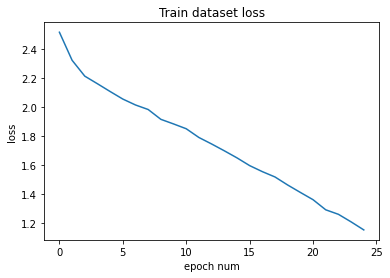

In [135]:
el_per_batch = math.ceil(len(train_X) / batch_size)

plot_results(list_to_plot=model.loss_list, 
             title='Train dataset loss', 
             xlab='epoch num', 
             ylab='loss')

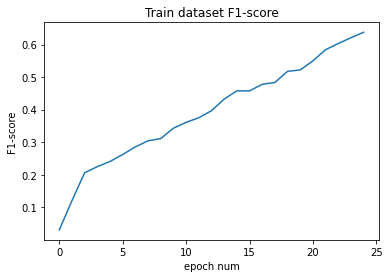

In [136]:
plot_results(list_to_plot=model.f1_list, 
             title='Train dataset F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

Test

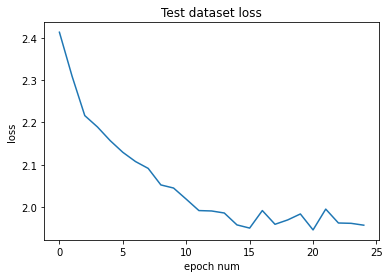

In [137]:
el_per_batch = math.ceil(len(test_X) / batch_size)

plot_results(list_to_plot=model.test_loss_list, 
             title='Test dataset loss', 
             xlab='epoch num', 
             ylab='loss')

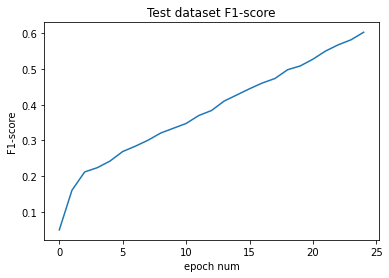

In [138]:
plot_results(list_to_plot=model.test_f1_list, 
             title='Test dataset F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

Validation

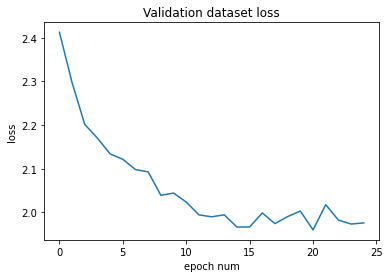

In [139]:
el_per_batch = math.ceil(len(val_X) / batch_size)

plot_results(list_to_plot=model.val_loss_list, 
             title='Validation dataset loss', 
             xlab='epoch num', 
             ylab='loss')

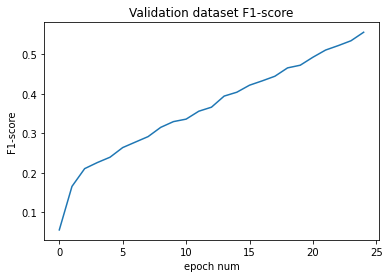

In [140]:
plot_results(list_to_plot=model.val_f1_list, 
             title='Validation dataset F1-score', 
             xlab='epoch num', 
             ylab='F1-score')

Confusion matrix

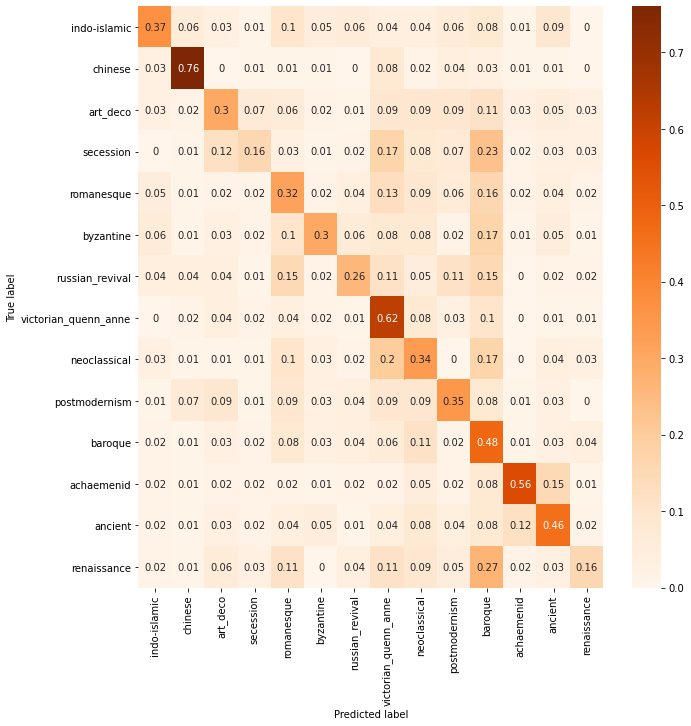

In [141]:
classes = list(dataset['labels_mapping'].keys())

test_X, test_y = get_data("test")
test_X = images_preprocessing(test_X)
test_y = labels_preprocessing(test_y)

y_pred = model.predict(test_X)

con_mat = tf.math.confusion_matrix(labels=test_y, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                          index = classes, 
                          columns = classes)

figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Oranges)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [142]:
def display_image_with_pred(image, pred_class):
    plt.imshow(image)
    title = 'Pred class: ' + str(pred_class)
    plt.title(title)
    plt.show()

===== REAL CLASS: indo-islamic =====


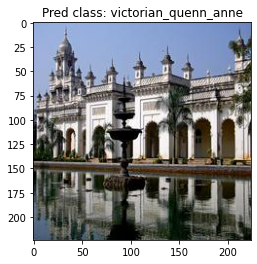

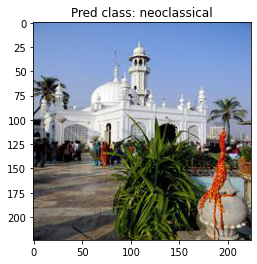

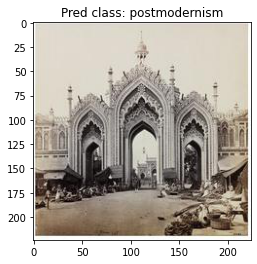

===== REAL CLASS: chinese =====


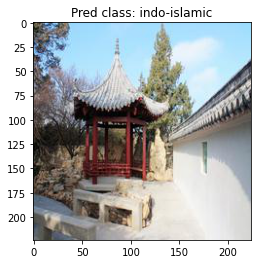

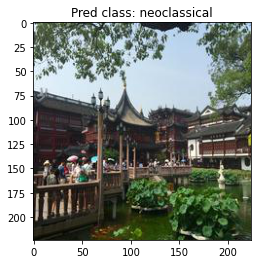

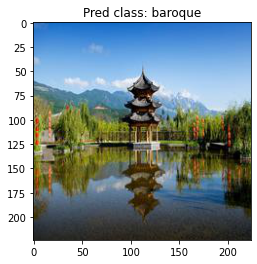

===== REAL CLASS: art_deco =====


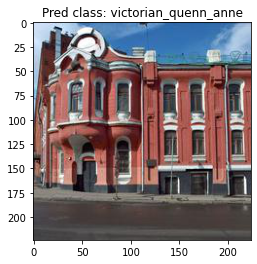

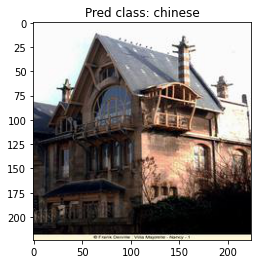

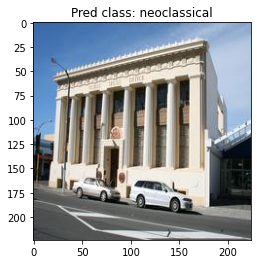

===== REAL CLASS: secession =====


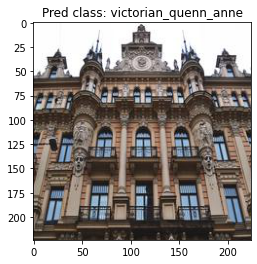

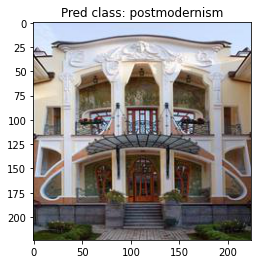

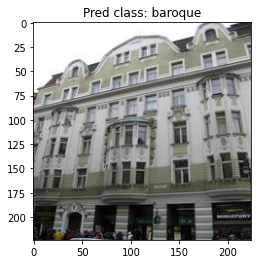

===== REAL CLASS: romanesque =====


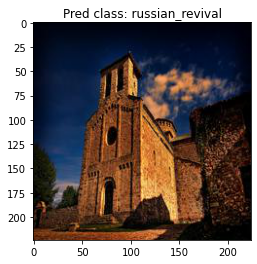

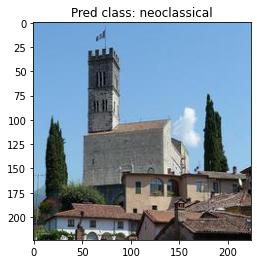

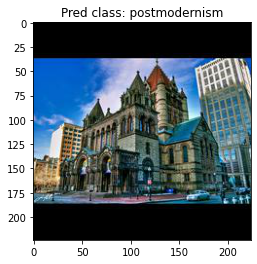

===== REAL CLASS: byzantine =====


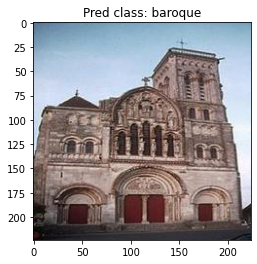

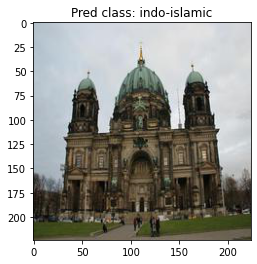

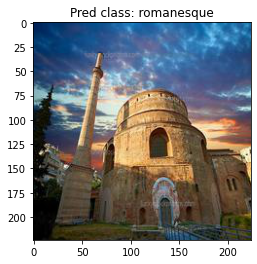

===== REAL CLASS: russian_revival =====


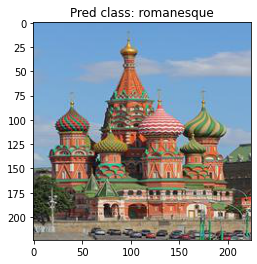

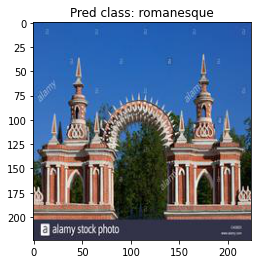

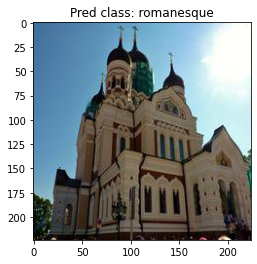

===== REAL CLASS: victorian_quenn_anne =====


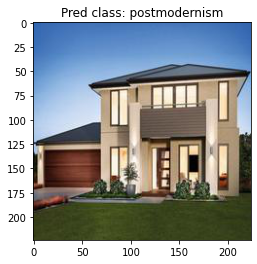

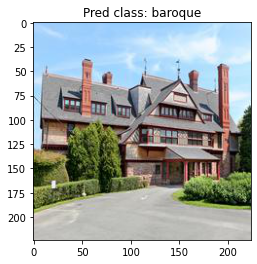

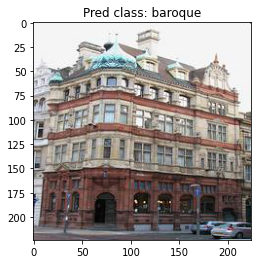

===== REAL CLASS: neoclassical =====


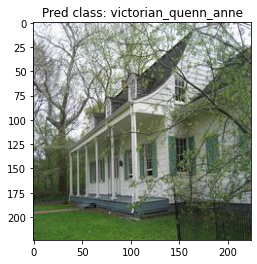

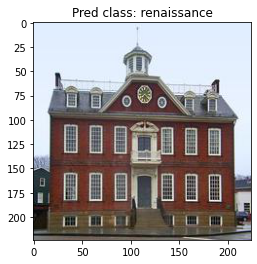

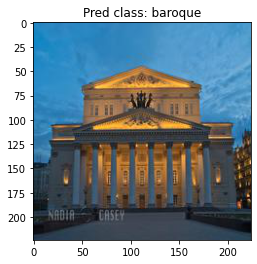

===== REAL CLASS: postmodernism =====


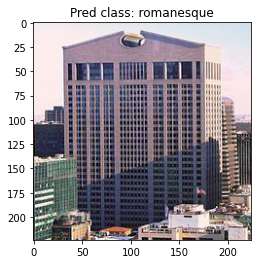

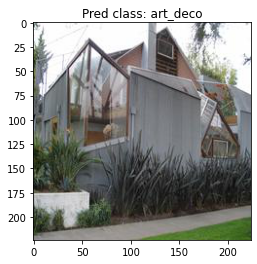

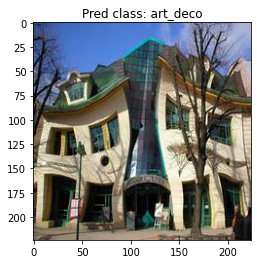

===== REAL CLASS: baroque =====


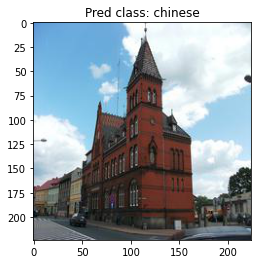

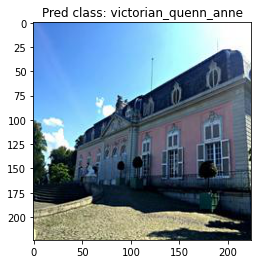

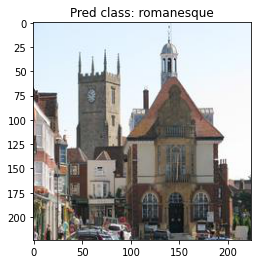

===== REAL CLASS: achaemenid =====


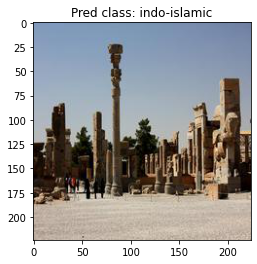

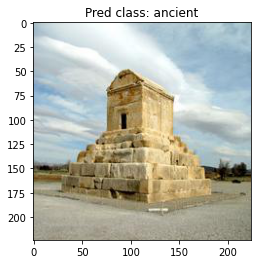

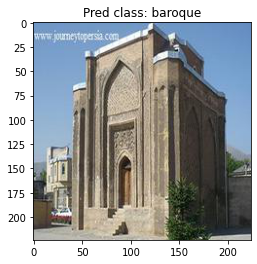

===== REAL CLASS: ancient =====


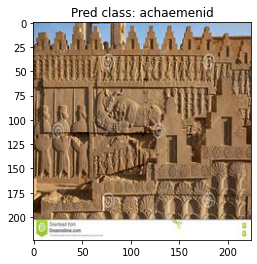

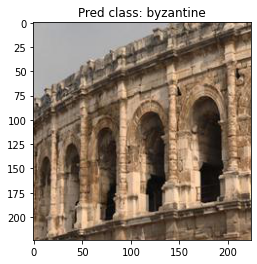

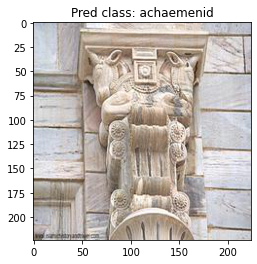

===== REAL CLASS: renaissance =====


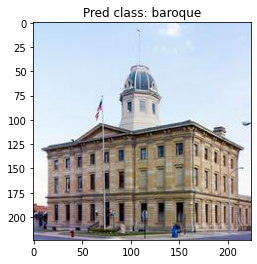

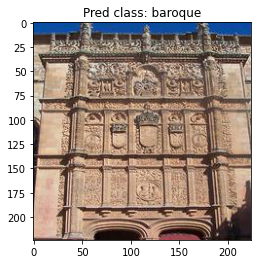

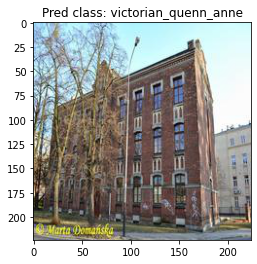

In [143]:
NUM_OF_INCORRRECT_PER_CLASS = 3

test_X, test_y = get_data("test")
test_y = labels_preprocessing(test_y)

for class_num in range(len(classes)):
    print('===== REAL CLASS:', classes[class_num], '=====')
    
    cnt = NUM_OF_INCORRRECT_PER_CLASS
    for image, label, pred in zip(test_X, test_y, y_pred):
        if label.numpy()[0] == class_num:
            if pred != label and cnt > 0:
                display_image_with_pred(image, classes[pred])
                cnt -= 1

### Podsumowanie
Wykorzystując model zrealizowany w części pierwszej zadania dotyczącego sieci konwolucyjnych, dokonano próby poprawienia jakości klasyfikacji.

No początku wykorzystano w tym celu podejście Data Augmentation - czyli powiększenie zbioru uczącego przez zastosowanie pewnych transformacji obrazu.

Zbadano wpływ na wyniki następujących wariandów podejścia, każdy z nich był realizowany co paczkę danych, z prawdopodobieństwem 50%:
- None - bez zmian
- flip - losowo odwrócenie obrazu w osi pionowej i poziomej
- rotate - losowo obrócenie obrazu o 0°, 90°, 180° lub 270°
- adjustments - wpływ na ustawienia barwy, nasycenia, jaskrawości oraz kontrastu
- random - trzy poprzednie wybrane w procesie stochastycznym

Niestety podejście Data Augmentation nie dało dobrych rezultatów. Najleprze wyniki (F1 = 0.403911) otrzymano dla usatwienia None.

Korzytsając z informacji zdobytych z poprzedniego eksperymentu, przetestowano dwie wybrane metody regularyzacji:
- Dropout - następujące podejścia:
    - None - bez warstw dropout
    - conv - warstwy dropout ze współczynnikiem 0.1 po warswach konwolucyjnych
    - dense - warstwy dropout ze współczynnikiem 0.5 po warswach w pełni połączonych
    - conv+dense - połączenie dwóch poprzednich wariantów
- Weight decay - następujące podejścia:
    - None - bez użycia weight decay
    - z użyciem z natępującymi współczynnikami {0.01, 0.001, 0.0001}
    - w zestawieniu ze współczynnikikami uczenia {0.001, 0.0001}

Regularyzacja poprawiła jakość klasyfikacji, porównuyjąc z wynikami z poprzedniej części zadania. Uzyskano wynik F1 = 0.412340.

Po dokonaniu ewaluacji znalezionej najlepszej konfiguracji na zbiorze testowym, przedstawiono wizualizacje otrzymanych rezultatów:
- zestawienie wartości metryki F1 w zależności od epoki (dla zbioru treningowego, walidacyjnego i testowego)
- wykresy krzywej funkcji kosztu w zależności od epoki (dla zbioru treningowego, walidacyjnego i testowego)
- krzywą funkcji kosztu w zależności od numeru epoki
- macierz pomyłek
- zwizualizowano kilka przykładów na klasę, dla których model podejmowal złą decyzję

### Wnioski
- Próba poprawienia jakości klasyfikacji przy pomocy regularyzacji przyniosła pozytywne rezultaty
- Za kożdym razem lepsze wyniki uzyskano wykorzystując podejście Dropout: conv+dense
- Lepsze wyniki daje niższe ustawienie weight decay, najlepsze natomiast nie używanie tej rergularyzacji
- Niższy współczynnik uzczenia daje lepsze wyniki z niższym ustawieniem weight decay oraz odwrotnie